In [53]:
# Imports
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import networkx as nx
from folium.plugins import MarkerCluster

In [3]:
# Read Files on Network Topology
pd_net_raw = pd.read_csv('network_parent_child.csv')
pd_dev_raw = pd.read_csv('device_geo_data.csv')
pd_dev_unique = pd.read_csv('devices.csv')

In [4]:
# pd_dev_loc = pd.merge(pd_net_raw,pd_dev_raw,on='geo_id')

In [5]:
# pd_import_list = []

# for file in os.listdir(os.getcwd() + '\\fbc'):
#     pd_import_list.append(pd.read_csv('fbc/' + file))
#     # print('Loaded {}'.format(file))

# pd_devices = pd.concat(pd_import_list)

In [6]:
# filelist = os.listdir(os.getcwd() + '\\fbc')

In [7]:
# ls_pointanalysis = []
# for df in filelist:
#     ls_pointanalysis.append(pd_dev_loc[pd_dev_loc.mac.isin(pd.read_csv('fbc/' + df).device_id.unique())])
# pd_loc_valid = pd.concat(ls_pointanalysis)

In [8]:
# pd_loc_valid.groupby('node')['geo_id'].unique().apply(len)
# pd_devices

<AxesSubplot:xlabel='device_type', ylabel='count'>

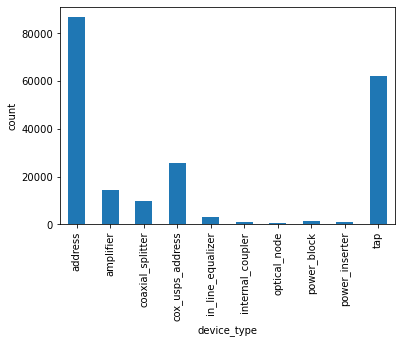

In [18]:
# Stats on number of devices, by type
pd_net_raw.groupby('device_type').count().rename(columns={'geo_id':'count'}) \
    ['count'].plot.bar(ylabel = 'count')

In [23]:
# Join tables for tail -> head information in directed graph
pd_links = pd_net_raw.merge(pd_net_raw, left_on='parent_id', right_on='geo_id', how='left', suffixes=['_tail','_head'])
pd_links.head()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
0,950351437,950351423.0,-83.759581,32.658571,tap,950351423.0,950351405.0,-83.759581,32.658571,amplifier
1,953550857,953550852.0,-83.586641,32.539248,tap,953550852.0,953550841.0,-83.586641,32.539248,in_line_equalizer
2,933436770,933436754.0,-83.713820,32.831317,tap,933436754.0,933436593.0,-83.713509,32.831229,tap
3,950348326,950348313.0,-83.754149,32.656190,tap,950348313.0,950348305.0,-83.754246,32.656532,tap
4,931035183,931035168.0,-83.690723,32.874315,tap,931035168.0,931035141.0,-83.690723,32.874315,amplifier


In [25]:
# Imputing location where the geo_id exists but lat/lon is missing, and lat/lon is available for the parent
pd_links_fill = pd_links[['geo_id_head','parent_id_head','lon_head','lat_head','device_type_head']]
pd_links_fill.columns = ['geo_id_tail','parent_id_tail','lon_tail','lat_tail','device_type_tail']
pd_links_fill['lat_tail'] = pd_links_fill.lat_tail + 0.0001
pd_links_fill['lon_tail'] = pd_links_fill.lon_tail + 0.0001
pd_links_fill.head()

C:\Users\MYShaw\AppData\Local\Temp/ipykernel_4332/3835432637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_links_fill['lat_tail'] = pd_links_fill.lat_tail + 0.0001
C:\Users\MYShaw\AppData\Local\Temp/ipykernel_4332/3835432637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_links_fill['lon_tail'] = pd_links_fill.lon_tail + 0.0001


,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail
0,950351423.0,950351405.0,-83.759481,32.658671,amplifier
1,953550852.0,953550841.0,-83.586541,32.539348,in_line_equalizer
2,933436754.0,933436593.0,-83.713409,32.831329,tap
3,950348313.0,950348305.0,-83.754146,32.656632,tap
4,931035168.0,931035141.0,-83.690623,32.874415,amplifier


In [26]:
pd_links = pd_links.fillna(pd_links_fill[['lon_tail','lat_tail']])
pd_links.head()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
0,950351437,950351423.0,-83.759581,32.658571,tap,950351423.0,950351405.0,-83.759581,32.658571,amplifier
1,953550857,953550852.0,-83.586641,32.539248,tap,953550852.0,953550841.0,-83.586641,32.539248,in_line_equalizer
2,933436770,933436754.0,-83.713820,32.831317,tap,933436754.0,933436593.0,-83.713509,32.831229,tap
3,950348326,950348313.0,-83.754149,32.656190,tap,950348313.0,950348305.0,-83.754246,32.656532,tap
4,931035183,931035168.0,-83.690723,32.874315,tap,931035168.0,931035141.0,-83.690723,32.874315,amplifier


In [118]:
G = nx.DiGraph()
# Filter links to only those valid. Terminating nodes are either optical nodes or cox USPS nodes
G.add_edges_from(pd_links[~pd_links.geo_id_head.isna()][['parent_id_tail','geo_id_tail']].to_numpy().astype(int).tolist())
G.add_nodes_from(pd_links.geo_id_tail.to_numpy())

In [143]:
ls_subgraphs = list(nx.weakly_connected_components(G))
ls_lengths = np.array([len(i) for i in ls_subgraphs])
# 1614 Connected Subgraphs Exist, with valid connections based on parent-child relationships
len(ls_subgraphs)

1614

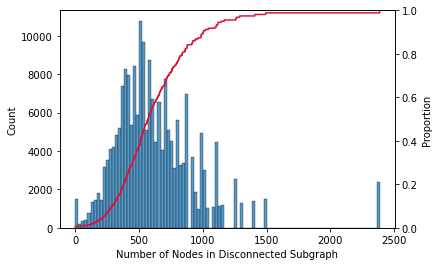

In [120]:
# Plotting CDF against
fig, ax = plt.subplots()
sns.histplot(x=ls_lengths, weights=ls_lengths, bins=100, ax=ax)
ax2 = ax.twinx()
sns.ecdfplot(x=ls_lengths, weights=ls_lengths, ax=ax2, color='crimson')
ax.set_xlabel('Number of Nodes in Disconnected Subgraph')
plt.show()

In [121]:
# Testing for if every disconnected subgraph is a tree
ls_is_tree = [nx.algorithms.tree.recognition.is_tree(G.subgraph(graph)) for graph in ls_subgraphs]

# True, every disconnected subgraph is a tree (no subgraph is not a tree)
False in ls_is_tree

False

In [130]:
# Graph Testing
G_test = G.subgraph(ls_subgraphs[2])
len(G_test.nodes())

115

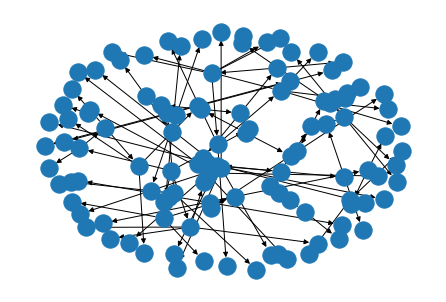

In [131]:
# Draw Graph
nx.draw_spring(G_test)

In [155]:
def find_subgraph(searchlist, graph):
    assert isinstance(searchlist, list)
    assert isinstance(graph, nx.DiGraph)
    
    searchlist = set(searchlist)
    ls_subgraphs = list(nx.weakly_connected_components(graph))

    for graph_nodes in ls_subgraphs:
        if searchlist.issubset(graph_nodes):
            return G.subgraph(graph_nodes)
    
    print('Nodes are from disconnected subgraphs')
    return None

Nodes are from disconnected subgraphs


In [187]:
def find_LCA(searchlist, graph):
    assert isinstance(searchlist, list)
    assert isinstance(graph, nx.DiGraph)
    
    searchlist = list(set(searchlist))
    
    if len(searchlist) == 1:
        lca, = searchlist
        return lca
    else:
        ((a,b),lca) = list(nx.algorithms.lowest_common_ancestors.tree_all_pairs_lowest_common_ancestor(graph, pairs=[(searchlist[0], find_LCA(searchlist[1:], graph))]))[0]
        return lca



950348148

In [188]:
ls_nodes_find=[950351872, 950353879, 950353817, 950353691, 950350208]

search_graph = find_subgraph(searchlist=ls_nodes_find, graph=G)
find_LCA(searchlist=ls_nodes_find, graph=search_graph)

950348148

In [86]:
# Create DF for plotting
pd_links_plot_a = pd_links[pd_links.geo_id_tail.isin(list(G_test.nodes()))]
pd_links_plot_a.head()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
0,950351437,950351423.0,-83.759581,32.658571,tap,950351423.0,950351405.0,-83.759581,32.658571,amplifier
3,950348326,950348313.0,-83.754149,32.656190,tap,950348313.0,950348305.0,-83.754246,32.656532,tap
21,950349911,950349892.0,-83.757570,32.666009,tap,950349892.0,950349708.0,-83.757556,32.665702,tap
39,950352038,950352024.0,-83.763280,32.656893,in_line_equalizer,950352024.0,950351998.0,-83.763001,32.657314,tap
47,950352190,950352180.0,-83.766719,32.659028,tap,950352180.0,950352172.0,-83.766455,32.659421,tap


In [336]:
# Start at mean location
startloc = [pd_net_pt_plot.lat_x.mean(), pd_net_pt_plot.lon_x.mean()]
my_map = folium.Map(location = startloc, zoom_start = 10)

# Create Feature Groups
feature_group_pt = folium.FeatureGroup("Locations")
feature_group_pl = folium.FeatureGroup("Connections")

# Define points to plot
pd_net_pt_plot = pd_links_plot_a

for lat, lng, name in pd_net_pt_plot[['lat_x','lon_x','device_type_x']].to_numpy():
    feature_group_pt.add_child(folium.Marker(location=[lat,lng],popup=name))

# Define Links to plot (Filter out links that are missing coordinates)
pd_net_pl_plot = pd_links_plot_a[~pd_links_plot_a.isna()[['lon_x','lat_x','lon_y','lat_y']].any(axis=1)]

for lat_x, lng_x, name, lat_y, lng_y in pd_net_pl_plot[['lat_x','lon_x','device_type_x','lat_y','lon_y']].to_numpy():
    feature_group_pl.add_child(folium.vector_layers.PolyLine(locations=[(lat_x,lng_x),(lat_y,lng_y)]))

# Add Feature Groups
my_map.add_child(feature_group_pt)
my_map.add_child(feature_group_pl)

# Show
my_map